# Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist.data, mnist.target

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

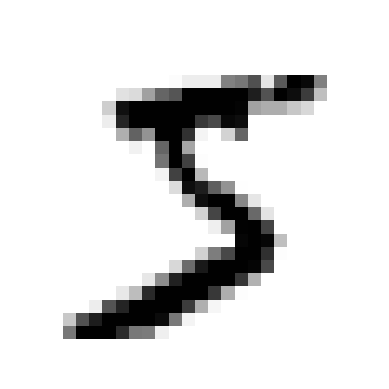

In [5]:
some_digit = X.iloc[0] # Selecting digit from Data
some_digit_image = some_digit.to_numpy().reshape(28,28) # Reshaping to 28x28 array
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest") # Converting to Matplotlib Representation
plt.axis("off")
plt.show()

In [6]:
import numpy as np

In [7]:
y = y.astype(np.uint8) # converting targets from string to integer

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # Splitting into Test and Train

## Binary Classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

C:\Users\alimu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance Measures

### Cross-Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.95035, 0.96035, and 0.96030

0.95035
0.96035
0.9604


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
# Dumb Classifier
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

<b>Over 90% accuracy. But this is because only 10% of the images are 5's. Guessing an image is not 5 will be correct 90% of the time.</b> <br>
<b>Hence, accuracy is generally not the preferred performance measure for classifiers, especially when dealing with <i>skewed</i> datasets.</b>

### Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

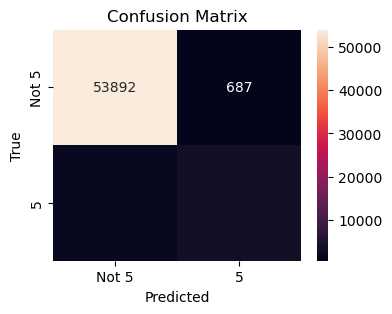

In [18]:
import seaborn as sns
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not 5', '5'], yticklabels=['Not 5', '5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
cm_perfect = confusion_matrix(y_train_5, y_train_perfect_predictions)
cm_perfect

array([[54579,     0],
       [    0,  5421]], dtype=int64)

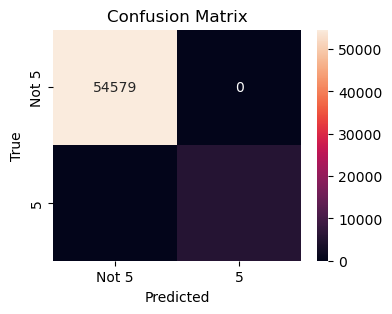

In [20]:
plt.figure(figsize=(4,3))
sns.heatmap(cm_perfect, annot=True, fmt='d', xticklabels=['Not 5', '5'], yticklabels=['Not 5', '5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Precision and Recall

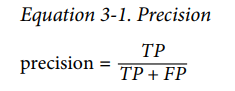

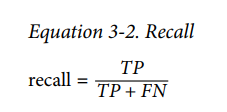

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

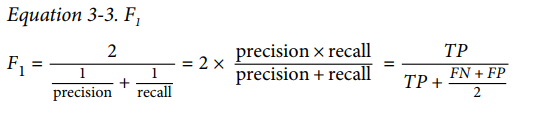

In [23]:
from sklearn.metrics import f1_score # harmonic mean between precision and recall
f1_score(y_train_5, y_train_pred)

0.7325171197343846

<b>Increasing precision reduces recall, and vice versa.</b>

### <u>Precision/Recall Tradeoff</u>

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\alimu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000 # Raising the threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function") # return decision functions

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

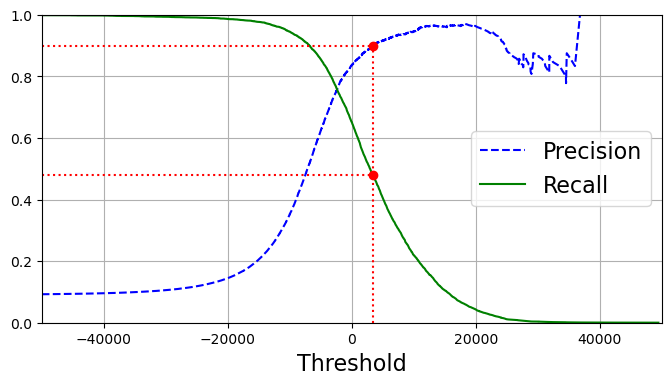

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])# highlight the threshold, add the legend, axis label and grid

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")    

plt.show()

Precision and Recall versus the decision threshold.

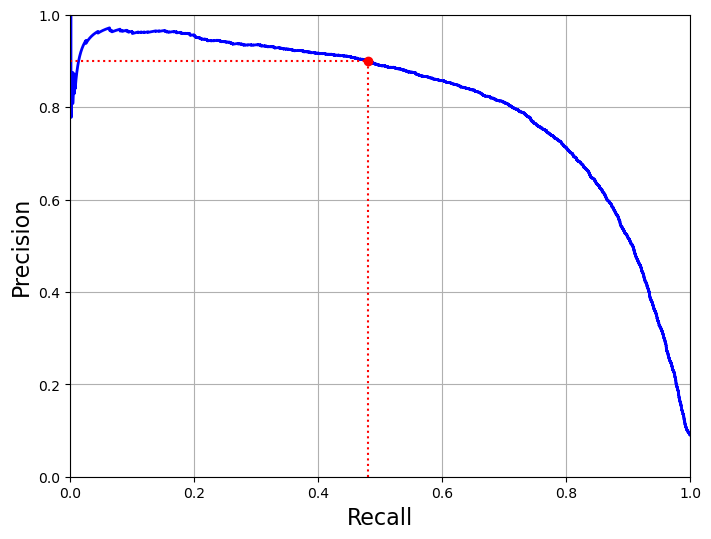

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

We can see that the precision starts to drop sharply after 80% recall, so we have to select a precision/recall tradeoff before that drop. (Maybe at 60%?)

In [31]:
# Supposing we need 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC Curve

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

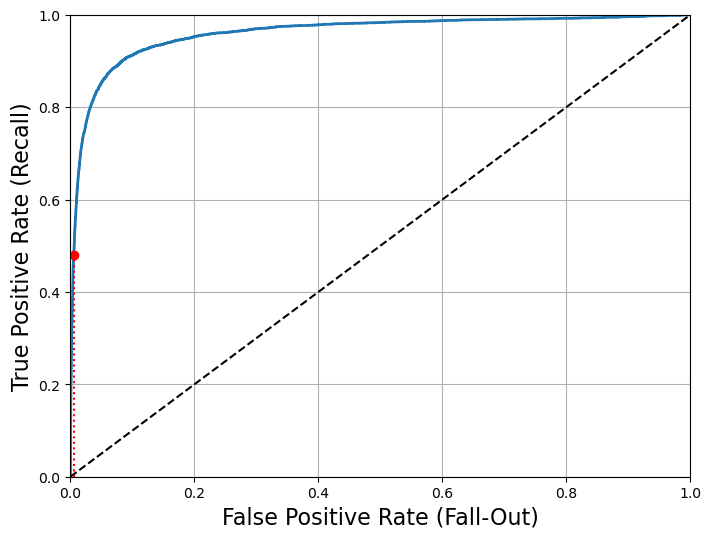

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                 # Not shown
plt.show()

We can measure AOC to determine how effective the classifier is:
<ul>
    <li>A perfect classifier will have a ROC AUC equal to 1.</li>
    <li>A purely random classifier will have  ROC AUC equal to 0.5</li>
</ul>

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<b>You should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.</b>

In [36]:
# Training a RandomForestClassifier to compare ROCC and ROC AUC
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [37]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

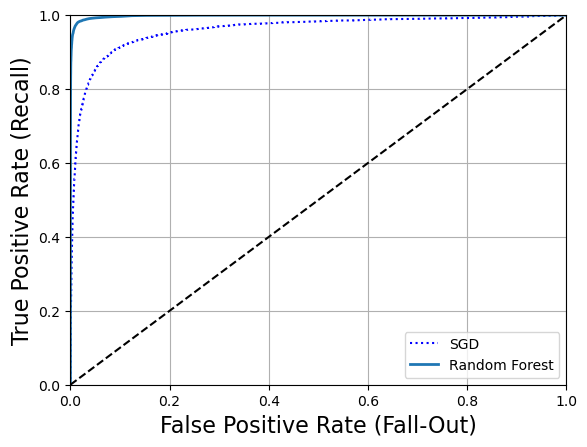

In [38]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [40]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [41]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

## Multiclass Classification
<ul>
    <li>One-Versus-One (OvO)</li>
    <li>One-Versus-All (OvA)</li>
</ul>

The main advantage of OvO is that each classifier only needs to be trained on the part of the trainingset for the two classes that it must distinguish. <br>
OvO is preferred since it is faster totrain many classifiers on small training sets than training few classifiers on largetraining sets

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

C:\Users\alimu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [43]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42)) # Forcing SGD to use OvO
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\alimu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [44]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

C:\Users\alimu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [45]:
forest_clf.predict_proba([some_digit])

C:\Users\alimu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [46]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
# simply scaling greatly increases the accuracy

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [48]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

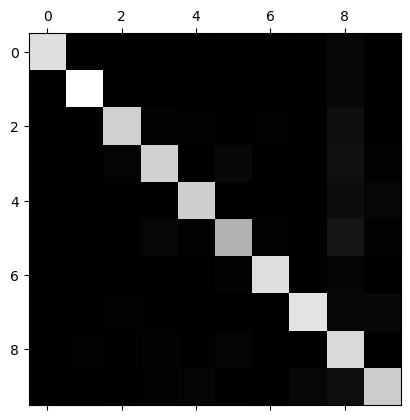

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # use error rates instead of total erros
norm_conf_mx = conf_mx/ row_sums

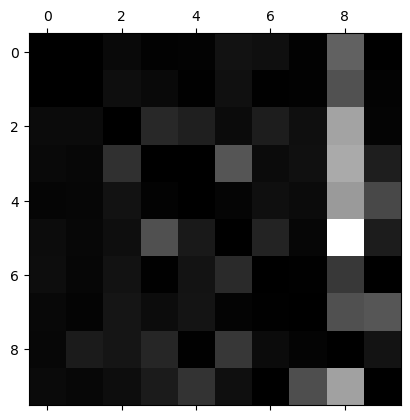

In [53]:
np.fill_diagonal(norm_conf_mx, 0) # fill diagonals wirth 0s to keep only the errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## <ul><li>Multilabel Classification</li><br><li>Multioutput Classification</li></ul>

# What we learned

## Chapter 3: Classfication
<h3><u>Main Highlights</u></h3>
<ol>
    <li>Exploring the MNIST Dataset</li>
    <li>Binary Classifiers</li>
    <li>Performance Measures</li>
    <ul><li>Cross-Validation</li><li>Confusion Matrix</li><li>Precision and Recall</li></ul>
    <li>Precision/Recall Tradeoff</li>
    <li>ROC Curve</li>
    <li>Multiclass Classification</li>
    <ul><li>One-Versus-One(OvO)</li><li>One-Versus-All (OvA)</li></ul>
    <li>Error Analysis</li>
    <li>Multilabel Classification</li>
    <li>Multioutput Classification</li>
</ol>